In [1]:
# !pip install pandas numpy scikit-learn torch pmdarima
# !conda install pmdarima -y

In [2]:
# check torch gpu
import torch

device = None

print("<!> Selecting GPU as main device <!>")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("<!> Using: " + torch.cuda.get_device_name(0) + "<!>")
else:
    print("<!> No GPU available <!>")
    exit(0)

<!> Selecting GPU as main device <!>
<!> Using: NVIDIA GeForce GTX 1050<!>


In [3]:
import pandas as pd

print("<!> Loading train dataframe <!>")
df = pd.read_csv('/root/test/train_transactions.csv')

<!> Loading train dataframe <!>


<!> Running AutoARIMA <!>


/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 


=== Evaluation for AutoARIMA ===
  - MAPE: 0.27
  - SMAPE: 31.85
  - MSE: 52599.84
  - RMSE: 229.35
  - R² Score: -1.32


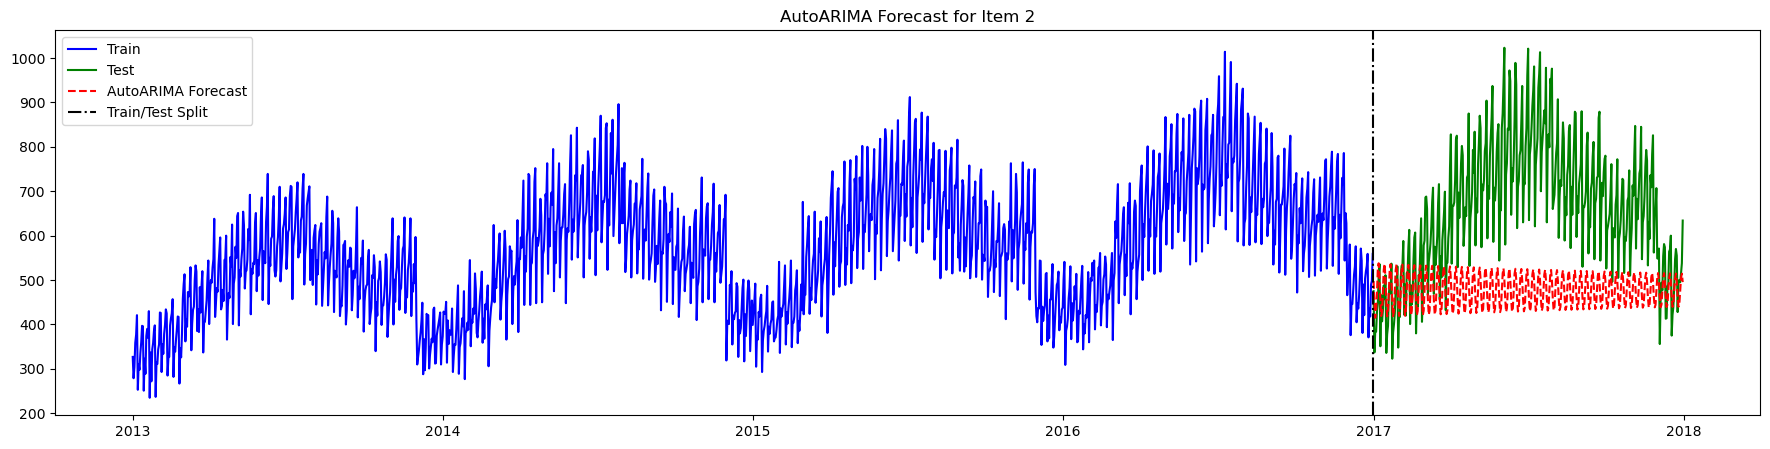

<!> Running AutoSARIMA <!>


/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 


=== Evaluation for AutoSARIMA ===
  - MAPE: 0.88
  - SMAPE: 139.57
  - MSE: 431472.60
  - RMSE: 656.87
  - R² Score: -18.06


/root/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


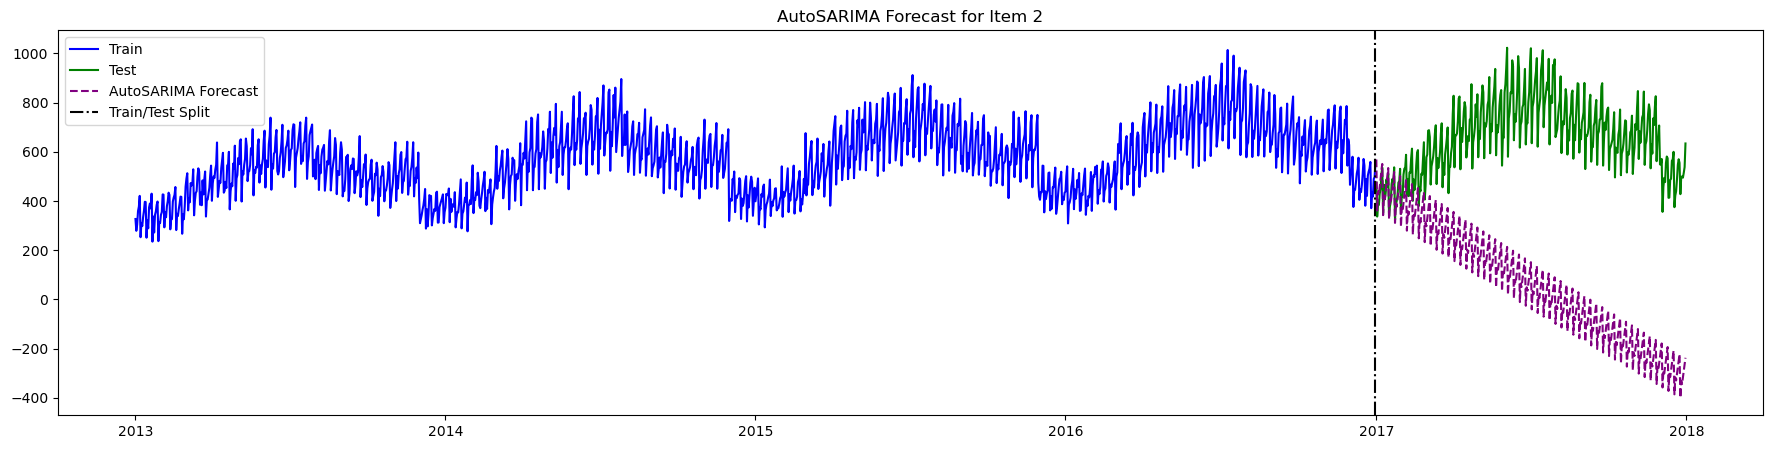

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt

df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Train-test split
train_df = df[df['date'] < '2017-01-01']
test_df = df[df['date'] >= '2017-01-01']

item_id = '2'
train_series = train_df[['date', item_id]].rename(columns={'date': 'ds', item_id: 'y'})
test_series = test_df[['date', item_id]].rename(columns={'date': 'ds', item_id: 'y'})

# Compute rolling averages as regressors
for window_size in [7, 14, 30]:
    train_series[f'rolling_avg_{window_size}'] = train_series['y'].rolling(window=window_size, min_periods=1).mean()
    test_series[f'rolling_avg_{window_size}'] = test_series['y'].rolling(window=window_size, min_periods=1).mean()

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return sum(abs((yt - yp) / yt) for yt, yp in zip(y_true, y_pred) if yt != 0) / len(y_true)

# Function to calculate SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * sum(2 * abs(yt - yp) / (abs(yt) + abs(yp)) for yt, yp in zip(y_true, y_pred) if yt + yp != 0) / len(y_true)

# Function to evaluate model
def evaluate_forecast(y_true, y_pred, model_name):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== Evaluation for {model_name} ===")
    print(f"  - MAPE: {mape:.2f}")
    print(f"  - SMAPE: {smape:.2f}")
    print(f"  - MSE: {mse:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R² Score: {r2:.2f}")

# Fit and forecast with AutoARIMA
print("<!> Running AutoARIMA <!>")
exog_train = train_series[['rolling_avg_7', 'rolling_avg_14', 'rolling_avg_30']]
exog_test = test_series[['rolling_avg_7', 'rolling_avg_14', 'rolling_avg_30']]

model_arima = auto_arima(train_series['y'], seasonal=False, stepwise=True, suppress_warnings=True, exogenous=exog_train)
arima_forecast = model_arima.predict(n_periods=len(test_series), exogenous=exog_test)
evaluate_forecast(test_series['y'].tolist(), arima_forecast.tolist(), "AutoARIMA")

plt.figure(figsize=(22, 5))
plt.plot(train_series['ds'], train_series['y'], label="Train", color="blue")
plt.plot(test_series['ds'], test_series['y'], label="Test", color="green")
plt.plot(test_series['ds'], arima_forecast, label="AutoARIMA Forecast", color="red", linestyle="dashed")
plt.axvline(train_series['ds'].iloc[-1], color="black", linestyle="-.", label="Train/Test Split")
plt.legend()
plt.title(f"AutoARIMA Forecast for Item {item_id}")
plt.show()

# Fit and forecast with AutoSARIMA (seasonal=True)
print("<!> Running AutoSARIMA <!>")
model_sarima = auto_arima(train_series['y'], seasonal=True, m=7, stepwise=True, suppress_warnings=True, exogenous=exog_train)
sarima_forecast = model_sarima.predict(n_periods=len(test_series), exogenous=exog_test)
evaluate_forecast(test_series['y'].tolist(), sarima_forecast.tolist(), "AutoSARIMA")

plt.figure(figsize=(22, 5))
plt.plot(train_series['ds'], train_series['y'], label="Train", color="blue")
plt.plot(test_series['ds'], test_series['y'], label="Test", color="green")
plt.plot(test_series['ds'], sarima_forecast, label="AutoSARIMA Forecast", color="purple", linestyle="dashed")
plt.axvline(train_series['ds'].iloc[-1], color="black", linestyle="-.", label="Train/Test Split")
plt.legend()
plt.title(f"AutoSARIMA Forecast for Item {item_id}")
plt.show()
